In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import normflows as nf
import random
from torch.utils.data import DataLoader
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
from scipy.stats import gaussian_kde
import yfinance as yf

from GPDFlow import T_mGPD_NF

from Common_Functions import empirical_tail_dependence_measure

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


# Load the Bank Data

The following code uses the yahoo finance API to download the historical stock price of the five banks. It might not work in the future due to the policy change of yahoo finance. If so, load the data financial_data.npy.

In [2]:
ticker = "JPM BAC C WFC MS" #Raw start="2005-01-01", end="2025-02-01"  "5d"

data = yf.download(ticker, start="2005-01-01", end="2025-02-01", interval='5d')
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Price           Close                                                 \
Ticker            BAC           C         JPM          MS        WFC   
Date                                                                   
2005-01-06  28.716856  309.665680   22.666548   30.455381  17.727642   
2005-01-11  28.691425  305.172363   22.192257   30.006241  17.659302   
2005-01-21  28.634302  303.336884   21.577431   29.625595  17.121059   
2005-01-26  29.066126  306.817780   21.565722   29.457008  17.334642   
2005-01-31  29.447142  310.425171   21.858492   30.430391  17.457098   
...               ...         ...         ...         ...        ...   
2024-12-27  44.061939   70.511726  239.930847  125.922119  70.760651   
2025-01-06  45.115292   72.239761  240.850006  127.789696  71.676132   
2025-01-16  46.347515   77.970085  254.270004  134.912292  75.576874   
2025-01-21  46.367390   81.108345  263.029999  136.392456  77.467537   
2025-01-31  46.009647   80.870003  267.299988  138.429993  78.412872   

Price            High                                                 ...  \
Ticker            BAC           C         JPM          MS        WFC  ...   
Date                                                                  ...   
2005-01-06  28.977225  311.627596   22.824646   30.639369  17.741881  ...   
2005-01-11  28.850187  306.817823   22.397198   30.330924  17.707715  ...   
2005-01-21  28.894672  306.944278   21.952183   30.131319  17.252060  ...   
2005-01-26  29.161382  308.083529   21.665264   29.685401  17.394447  ...   
2005-01-31  29.485245  312.007358   21.899480   30.468456  17.485577  ...   
...               ...         ...         ...         ...        ...  ...   
2024-12-27  44.499179   71.038080  242.139442  127.014847  71.387553  ...   
2025-01-06  45.860588   73.481165  245.690002  129.091034  72.890140  ...   
2025-01-16  47.212058   78.218366  257.040009  135.250041  76.064472  ...   
2025-01-21  46.854319   81.287107  264.250000  136.710333  77.905378  ...   
2025-01-31  46.536326   81.773741  270.820007  139.759995  78.900463  ...   

Price            Open                                                 \
Ticker            BAC           C         JPM          MS        WFC   
Date                                                                   
2005-01-06  28.843864  308.842950   22.701681   30.276806  17.684924   
2005-01-11  28.672375  305.868510   22.309365   30.330924  17.670693   
2005-01-21  28.742259  306.944278   21.811651   29.821359  17.203646   
2005-01-26  29.040723  307.070945   21.548154   29.625583  17.229274   
2005-01-31  29.180423  310.108733   21.829213   29.924668  17.388751   
...               ...         ...         ...         ...        ...   
2024-12-27  43.962568   70.372690  241.472886  126.210203  70.830306   
2025-01-06  44.876795   71.733274  243.699997  126.786370  71.576625   
2025-01-16  46.705258   77.294761  254.000000  131.475172  75.477367   
2025-01-21  46.327640   79.876875  260.070007  135.538140  77.308327   
2025-01-31  46.407140   81.128217  269.230011  139.139999  78.303412   

Price         Volume                                          
Ticker           BAC         C       JPM        MS       WFC  
Date                                                          
2005-01-06  14602200   1804990   9115900   5991400   8887600  
2005-01-11   8900700   1295270   8966300   4113800   7490800  
2005-01-21   8258900   1937040  14174400   4884300   6870600  
2005-01-26   7771400   1487690  14555600   5381700   7278400  
2005-01-31  10799200   1914920  14111800   5418400   6569800  
...              ...       ...       ...       ...       ...  
2024-12-27  17972500   7743100   5730200   3088100   7219500  
2025-01-06  30518500  19199700   9917800   6665200  15565600  
2025-01-16  56339300  21463100  15292300  16235700  22897900  
2025-01-21  52089100  21297400  13712100  11213300  21057700  
2025-01-31  30392900  12821400   7196300   5503400  14983800  

[1011 rows x 25 colu

In [ ]:
neg_log_return = {}

for company in data['Close'].columns:
    neg_log_return[company] = -(np.log(data['Close'][company]) - np.log(data['Close'][company].shift(1)))

df_neg_log_return = pd.DataFrame(neg_log_return)
df_neg_log_return = df_neg_log_return.iloc[1:,:]

samples_origin = df_neg_log_return.values


In [2]:
dir_out = "Data_and_Model/"
with open(dir_out + f'financial_data.npy', 'rb') as f:
    samples_origin = np.load(f)

# Exploratory Analysis 

#### Check the tail dependence by $\chi_{1:5}(q)$ and $\omega_{1:5}(q)$

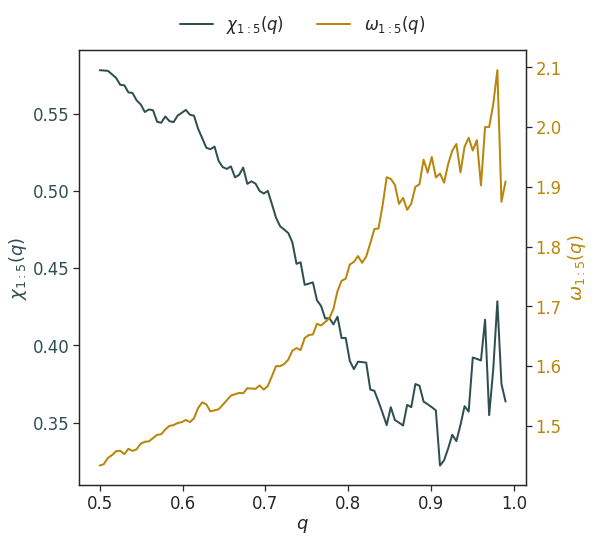

In [3]:
probs = np.linspace(0.50, 0.99, 100)
chi_emp   = [empirical_tail_dependence_measure(samples_origin, p, 'and') for p in probs]
omega_emp = [empirical_tail_dependence_measure(samples_origin, p, 'or') for p in probs]

# Create a figure and axis
sns.set(style="ticks",font_scale=1.5)
fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot chi (for 'and') on the left y-axis
color_chi = 'darkslategray'
ax1.plot(probs, chi_emp, color=color_chi, linewidth=2, label=r'$\chi_{1:5}(q)$')
ax1.set_xlabel(r'$q$')
ax1.set_ylabel(r'$\chi_{1:5}(q)$', color=color_chi)
ax1.tick_params(axis='y', labelcolor=color_chi)

# Create a twin axis for omega (for 'or')
ax2 = ax1.twinx()
color_omega = 'darkgoldenrod'
ax2.plot(probs, omega_emp, color=color_omega, linewidth=2, label=r'$\omega_{1:5}(q)$')
ax2.set_ylabel(r'$\omega_{1:5}(q)$', color=color_omega)
ax2.tick_params(axis='y', labelcolor=color_omega)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
plt.savefig(dir_out + 'Plots/'+'threshold_selection.pdf',bbox_inches='tight')
plt.show()

#### Scatter plot of the raw data

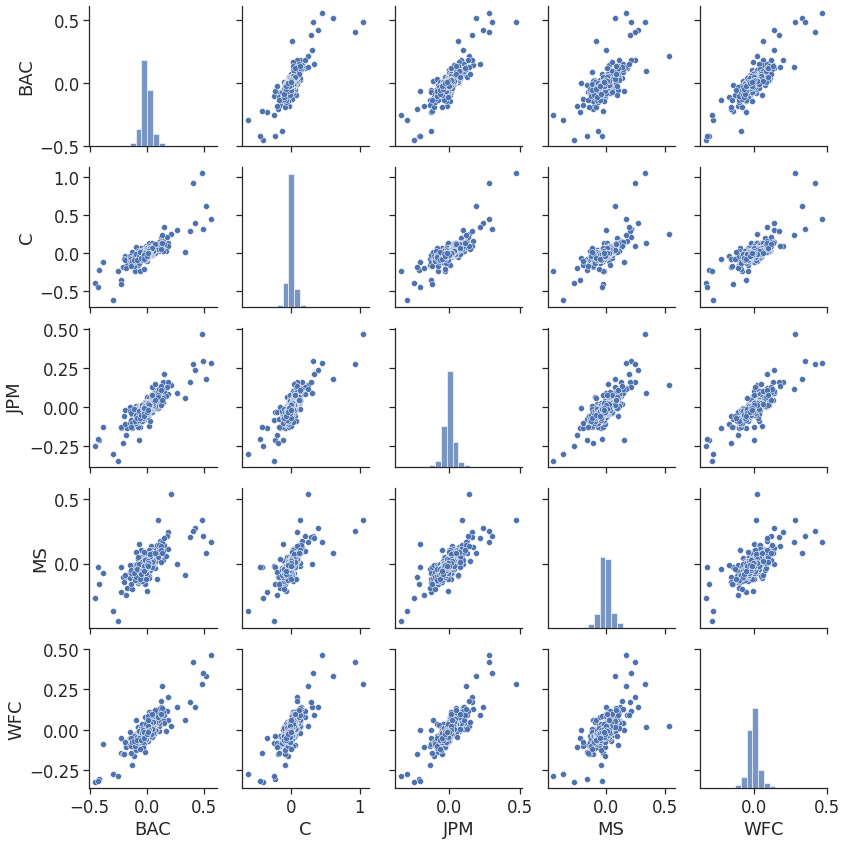

In [4]:
df = pd.DataFrame(samples_origin)
df.columns = ['BAC','C','JPM','MS','WFC']
sns.set(style="ticks",font_scale=1.5)
g = sns.pairplot(df, diag_kws={'bins': 20})
g.fig.set_size_inches(12, 12)
plt.savefig(dir_out + 'Plots/'+'neg_log_return.pdf',bbox_inches='tight')
plt.show()


# Model fitting 

#### Prepare the threshold exceedance data

In [ ]:
thres_origin = np.quantile(samples_origin, 0.95,axis=0)

cond = np.any(samples_origin > thres_origin, axis =1)
    
samples = samples_origin[cond,:]

thres = thres_origin.reshape(1,-1)
samples = samples - thres
print(samples.shape)



(100, 5)
0.00G GPU memory allocated


#### Hyperparameter tuning

In [10]:
seed = 1234
rng = np.random.default_rng(seed)  # set seed for reproducibility (change/remove if you want)
idx = rng.permutation(len(samples))

split = int(0.8 * len(samples))
train_idx, val_idx = idx[:split], idx[split:]

train_samples = samples[train_idx]
val_samples   = samples[val_idx]

In [11]:
def build_realnvp_flow(dim: int, num_layers: int, hidden_mult: int, device):
    """
    Builds a RealNVP-like flow using MaskedAffineFlow + ActNorm blocks.
    hidden_mult controls the middle layer width: hidden_mult * latent_size
    """
    base = nf.distributions.DiagGaussian(dim)
    latent_size = dim
    b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)]).to(device)

    flows = []
    for i in range(num_layers):
        hidden = hidden_mult * latent_size
        s = nf.nets.MLP([latent_size, hidden, latent_size], init_zeros=True, output_fn='tanh')
        t = nf.nets.MLP([latent_size, hidden, latent_size], init_zeros=True, output_fn='tanh')
        if i % 2 == 0:
            flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
        flows += [nf.flows.ActNorm(latent_size)]

    flow_model = nf.NormalizingFlow(base, flows).to(device)
    return flow_model

def train_one_setting(
    *,
    dim: int,
    num_layers: int,
    hidden_mult: int,
    device,
    train_samples,
    val_samples,
    seed: int = 1234,
    epochs: int = 200,
    batch_size: int = 64,
    patience: int = 100,
    min_delta: float = 0.0,
    weight_decay: float = 1e-5,
    lr_flow: float = 1e-2,
    lr_log_sigma: float = 1e-1,
    lr_theta: float = 1e-1,
):
    """
    Returns:
      result dict with:
        best_val, best_epoch, final_epoch, histories, and best_state (CPU tensors)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # tensors + loaders
    train_data = torch.tensor(np.asarray(train_samples), dtype=torch.float32, device=device)
    val_data   = torch.tensor(np.asarray(val_samples),   dtype=torch.float32, device=device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, drop_last=False)

    # build flow + wrapper model
    f_T_model = build_realnvp_flow(dim=dim, num_layers=num_layers, hidden_mult=hidden_mult, device=device)

    model = T_mGPD_NF(
        dim=dim,
        flow=f_T_model,
        device=device,
        s_min=-10,
        s_max=10,
        num_integration_points=1000,
        penalty_lambda=10000,
        fix_margin=False
    ).to(device)

    optimizer = torch.optim.Adam(
        [
            {'params': model.flow_model.parameters(), 'lr': lr_flow},
            {'params': model.data_transform.log_sigma, 'lr': lr_log_sigma},
            {'params': model.data_transform.theta,     'lr': lr_theta},
        ],
        weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    best_val = float("inf")
    best_state = None
    best_epoch = -1
    bad_epochs = 0

    train_hist, val_hist = [], []

    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        # ---------------- TRAIN ----------------
        model.train()
        train_epoch_loss = 0.0
        train_count = 0

        for x_data in train_loader:
            batch_loss = model(x_data)

            if torch.isnan(batch_loss) or torch.isinf(batch_loss):
                print(f"[Grid] NaN/Inf in TRAIN | layers={num_layers} hidden_mult={hidden_mult} epoch={epoch}")
                bad_epochs = patience  # force stop
                break

            optimizer.zero_grad(set_to_none=True)
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            bsz = x_data.shape[0]
            train_epoch_loss += batch_loss.item() * bsz
            train_count += bsz

        train_epoch_loss = train_epoch_loss / max(train_count, 1)
        train_hist.append(train_epoch_loss)

        # ---------------- VALIDATION ----------------
        model.eval()
        val_epoch_loss = 0.0
        val_count = 0
        with torch.no_grad():
            for x_val in val_loader:
                vloss = model(x_val)
                if torch.isnan(vloss) or torch.isinf(vloss):
                    print(f"[Grid] NaN/Inf in VAL | layers={num_layers} hidden_mult={hidden_mult} epoch={epoch}")
                    bad_epochs = patience
                    break
                bsz = x_val.shape[0]
                val_epoch_loss += vloss.item() * bsz
                val_count += bsz

        val_epoch_loss = val_epoch_loss / max(val_count, 1)
        val_hist.append(val_epoch_loss)

        scheduler.step()

        # ---------------- EARLY STOPPING on VAL ----------------
        improved = (best_val - val_epoch_loss) > min_delta
        if improved:
            best_val = val_epoch_loss
            best_epoch = epoch
            bad_epochs = 0
            # keep best weights for this hyperparam setting
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad_epochs += 1

        # optional logging per epoch (comment out if too chatty)
        # print(f"[Grid] layers={num_layers:2d} hidden_mult={hidden_mult:2d} "
        #       f"epoch={epoch+1:3d}/{epochs} train={train_epoch_loss:.6f} val={val_epoch_loss:.6f}")

        if bad_epochs >= patience:
            break

    result = {
        "num_layers": num_layers,
        "hidden_mult": hidden_mult,
        "best_val": float(best_val),
        "best_epoch": int(best_epoch),
        "final_epoch": int(epoch),
        "train_history": train_hist,
        "val_history": val_hist,
        "best_state": best_state,  # CPU tensors
    }
    return result

# ----------------------------
# DEFINE YOUR GRID
# ----------------------------
num_layers_grid = [4, 8, 12, 16]      # example; edit as desired
hidden_mult_grid = [2, 4, 6, 8]          # middle layer = hidden_mult * latent_size

# ----------------------------
# RUN GRID SEARCH
# ----------------------------
grid_results = []
best_overall = None

dim = 5
batch_size = 64
epochs = 200
patience = 50          # how many epochs w/o improvement before stopping
min_delta = 0.0        # minimum improvement to reset patience
best_val = float("inf")
best_state = None
bad_epochs = 0

for nl in num_layers_grid:
    for hm in hidden_mult_grid:
        print(f"\n=== Training setting: num_layers={nl}, hidden_mult={hm} ===")
        res = train_one_setting(
            dim=dim,
            num_layers=nl,
            hidden_mult=hm,
            device=device,
            train_samples=train_samples,
            val_samples=val_samples,
            seed=seed,
            epochs=epochs,
            batch_size=batch_size,
            patience=patience,
            min_delta=min_delta,
            weight_decay=1e-5,
            lr_flow=1e-2,
            lr_log_sigma=1e-1,
            lr_theta=1e-1,
        )
        grid_results.append(res)

        print(f"--> best_val={res['best_val']:.6f} at epoch {res['best_epoch']+1}")

        if (best_overall is None) or (res["best_val"] < best_overall["best_val"]):
            best_overall = res

# ----------------------------
# REPORT + RESTORE BEST SETTING
# ----------------------------
print("\n====================")
print("GRID SEARCH COMPLETE")
print("====================")
print(f"Best hyperparams: num_layers={best_overall['num_layers']}, hidden_mult={best_overall['hidden_mult']}")
print(f"Best val loss: {best_overall['best_val']:.6f} (epoch {best_overall['best_epoch']+1})")



=== Training setting: num_layers=4, hidden_mult=2 ===
--> best_val=-8.291614 at epoch 71

=== Training setting: num_layers=4, hidden_mult=4 ===
--> best_val=-8.599121 at epoch 110

=== Training setting: num_layers=4, hidden_mult=6 ===
--> best_val=-8.133231 at epoch 56

=== Training setting: num_layers=4, hidden_mult=8 ===
--> best_val=-7.984509 at epoch 77

=== Training setting: num_layers=8, hidden_mult=2 ===
--> best_val=-8.228643 at epoch 67

=== Training setting: num_layers=8, hidden_mult=4 ===
--> best_val=-8.193282 at epoch 73

=== Training setting: num_layers=8, hidden_mult=6 ===
--> best_val=-7.411937 at epoch 43

=== Training setting: num_layers=8, hidden_mult=8 ===
--> best_val=-8.281075 at epoch 81

=== Training setting: num_layers=12, hidden_mult=2 ===
--> best_val=-7.816818 at epoch 72

=== Training setting: num_layers=12, hidden_mult=4 ===
--> best_val=-7.997762 at epoch 59

=== Training setting: num_layers=12, hidden_mult=6 ===
--> best_val=-8.236250 at epoch 55

=== T

In [12]:
pd.DataFrame({'num_layers':[a['num_layers'] for a in grid_results],
              'hidden_mult': [a['hidden_mult'] for a in grid_results],
              'best_val': [round(a['best_val'],2) for a in grid_results],
              'best_epoch': [a['best_epoch'] for a in grid_results], })

,num_layers,hidden_mult,best_val,best_epoch
0,4,2,-8.29,70
1,4,4,-8.60,109
2,4,6,-8.13,55
3,4,8,-7.98,76
4,8,2,-8.23,66
5,8,4,-8.19,72
6,8,6,-7.41,42
7,8,8,-8.28,80
8,12,2,-7.82,71
9,12,4,-8.00,58


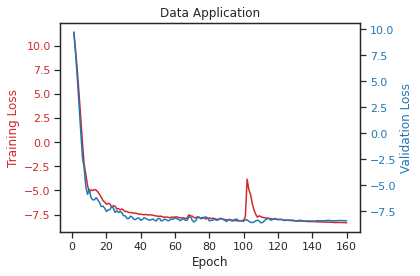

In [34]:
sns.set(style="ticks",font_scale=1)
fig, ax1 = plt.subplots()
epochs = range(1, len(best_overall['train_history']) + 1)
color1 = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color1)
ax1.plot(epochs, best_overall['train_history'], color=color1, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color1)

# Validation loss is calculated every 20 epochs.
# Create a list of epochs corresponding to validation measurements

# Create a second y-axis for validation loss
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color2)
ax2.plot(epochs, best_overall['val_history'], color=color2, label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Data Application')


# sns.set(style="ticks",font_scale=1)
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+'Train_val_loss_application.pdf',bbox_inches='tight')
plt.show()

sns.set(style="ticks",font_scale=1.5)

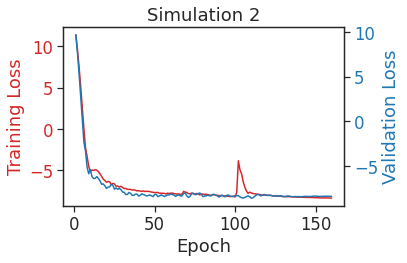

In [33]:
fig, ax1 = plt.subplots()
epochs = range(1, len(best_overall['train_history']) + 1)
color1 = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color1)
ax1.plot(epochs, best_overall['train_history'], color=color1, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color1)

# Validation loss is calculated every 20 epochs.
# Create a list of epochs corresponding to validation measurements

# Create a second y-axis for validation loss
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color2)
ax2.plot(epochs, best_overall['val_history'], color=color2, label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Simulation 2')


# sns.set(style="ticks",font_scale=1)
plt.tight_layout()
# plt.savefig(dir_out + 'Plots/'+'Train_val_loss_simulation_2.pdf',bbox_inches='tight')
plt.show()

In [30]:
dir_out + 'Plots/'+'Train_val_loss_application.pdf'

'Data_and_Model/Plots/Train_val_loss_application.pdf'

#### Train the GPDFlow
Visualize the estimation by plotting the samples every 50 epoches.

Epoch 1/200, Loss: 0.6157
Epoch 0 - Learning Rate: 0.01


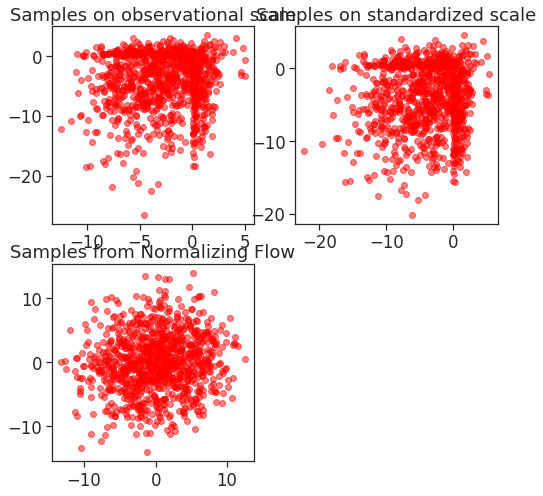

Epoch 2/200, Loss: 0.5194
Epoch 1 - Learning Rate: 0.009999383162408303
Epoch 3/200, Loss: 0.4096
Epoch 2 - Learning Rate: 0.009997532801828657
Epoch 4/200, Loss: 0.2888
Epoch 3 - Learning Rate: 0.00999444937480985
Epoch 5/200, Loss: 0.1590
Epoch 4 - Learning Rate: 0.009990133642141357
Epoch 6/200, Loss: 0.0291
Epoch 5 - Learning Rate: 0.009984586668665639
Epoch 7/200, Loss: -0.0747
Epoch 6 - Learning Rate: 0.009977809823015398
Epoch 8/200, Loss: -0.1757
Epoch 7 - Learning Rate: 0.009969804777275897
Epoch 9/200, Loss: -0.1950
Epoch 8 - Learning Rate: 0.009960573506572387
Epoch 10/200, Loss: -0.1908
Epoch 9 - Learning Rate: 0.009950118288582784
Epoch 11/200, Loss: -0.2413
Epoch 10 - Learning Rate: 0.009938441702975684
Epoch 12/200, Loss: -0.2871
Epoch 11 - Learning Rate: 0.009925546630773864
Epoch 13/200, Loss: -0.2995
Epoch 12 - Learning Rate: 0.009911436253643439
Epoch 14/200, Loss: -0.3225
Epoch 13 - Learning Rate: 0.009896114053108824
Epoch 15/200, Loss: -0.3390
Epoch 14 - Learning 

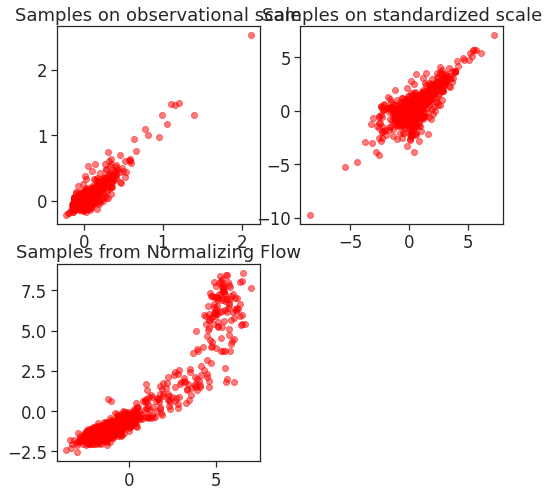

Epoch 52/200, Loss: -0.4476
Epoch 51 - Learning Rate: 0.008479563982961562
Epoch 53/200, Loss: -0.4469
Epoch 52 - Learning Rate: 0.008422735529643434
Epoch 54/200, Loss: -0.4404
Epoch 53 - Learning Rate: 0.008365062567548856
Epoch 55/200, Loss: -0.4443
Epoch 54 - Learning Rate: 0.00830655932661825
Epoch 56/200, Loss: -0.4453
Epoch 55 - Learning Rate: 0.008247240241650909
Epoch 57/200, Loss: -0.4376
Epoch 56 - Learning Rate: 0.00818711994874344
Epoch 58/200, Loss: -0.4520
Epoch 57 - Learning Rate: 0.008126213281678518
Epoch 59/200, Loss: -0.4526
Epoch 58 - Learning Rate: 0.008064535268264873
Epoch 60/200, Loss: -0.4431
Epoch 59 - Learning Rate: 0.008002101126629411
Epoch 61/200, Loss: -0.4507
Epoch 60 - Learning Rate: 0.007938926261462358
Epoch 62/200, Loss: -0.4386
Epoch 61 - Learning Rate: 0.007875026260216385
Epoch 63/200, Loss: -0.4459
Epoch 62 - Learning Rate: 0.007810416889260647
Epoch 64/200, Loss: -0.4489
Epoch 63 - Learning Rate: 0.007745114089990651
Epoch 65/200, Loss: -0.4455

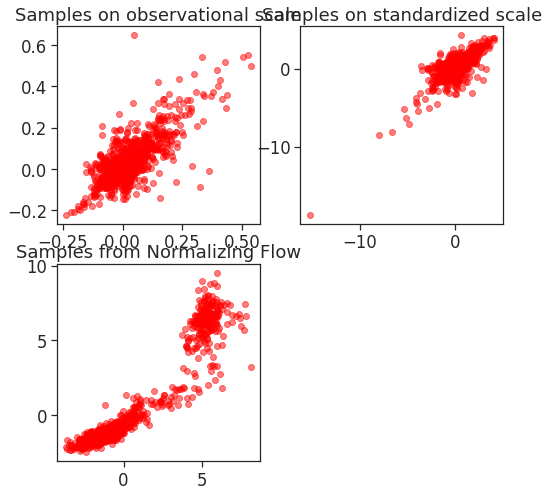

Epoch 102/200, Loss: -0.4555
Epoch 101 - Learning Rate: 0.004921463413440894
Epoch 103/200, Loss: -0.4545
Epoch 102 - Learning Rate: 0.004842946204609355
Epoch 104/200, Loss: -0.4483
Epoch 103 - Learning Rate: 0.004764467746451784
Epoch 105/200, Loss: -0.4564
Epoch 104 - Learning Rate: 0.00468604740235343
Epoch 106/200, Loss: -0.4509
Epoch 105 - Learning Rate: 0.004607704521360773
Epoch 107/200, Loss: -0.4557
Epoch 106 - Learning Rate: 0.0045294584334074255
Epoch 108/200, Loss: -0.4672
Epoch 107 - Learning Rate: 0.004451328444544771
Epoch 109/200, Loss: -0.4619
Epoch 108 - Learning Rate: 0.004373333832178476
Epoch 110/200, Loss: -0.4501
Epoch 109 - Learning Rate: 0.004295493840312086


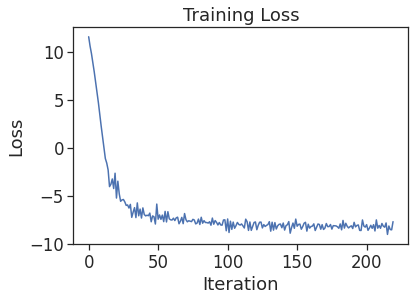

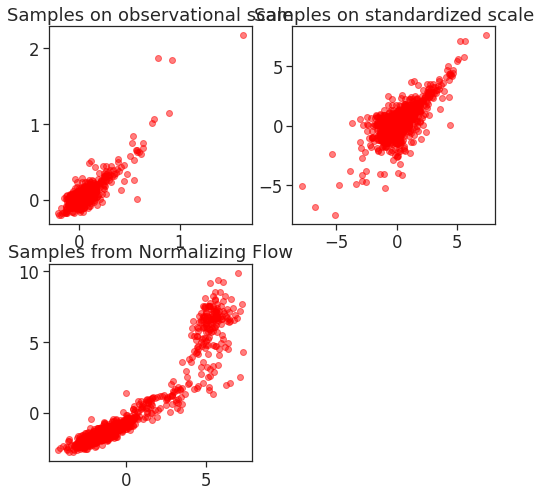

In [23]:
dim = 5
base = nf.distributions.DiagGaussian(dim)

hidden_mult = best_overall['hidden_mult']
num_layers = best_overall['num_layers']
epochs = 200
best_epoch = best_overall['best_epoch']

torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, hidden_mult * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, hidden_mult * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 64
loss_history = []


model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)

optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)



Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    epoch_loss = 0.0
    
    for x_data in Training_Data:
        # Sample a batch of data from h_U

        batch_loss = model(x_data)
        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)


        optimizer.step()

        # Record loss
        loss_history.append(batch_loss.item())
        epoch_loss += batch_loss.item()

        if torch.isnan(batch_loss) or torch.isinf(batch_loss):
            print("NaN or Inf detected!")
            break

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(x_data):.4f}")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Learning Rate: {current_lr}")


    if epoch % 50 ==0:
        # samples_obs: predicted threshold exceedance data from the GPDFlow
        # samples_std: predicted standardized threshold exceedance data, i.e. sigma = 1, gamma =0
        # samples_T: samples from the normalizing flow 
        samples_obs, samples_std, samples_T= model.sample(1000)
        plt.figure(figsize=(8,8))
        plt.subplot(2, 2, 1)
        plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on observational scale')
        plt.subplot(2, 2, 2)
        plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on standardized scale')
        plt.subplot(2, 2, 3)
        plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples from Normalizing Flow')
        plt.show()

    scheduler.step()

    if epoch == best_epoch:
        break

torch.save(model.state_dict(), dir_out + f'model_finance_application.pt')  

# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

samples_obs, samples_std, samples_T= model.sample(1000)
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on observational scale')
plt.subplot(2, 2, 2)
plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on standardized scale')
plt.subplot(2, 2, 3)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.show()

# Model Comparisons

Ouput the threshold exceedance data as csv for R to read.

The mGPD in Kiriliouk's paper is fitted in R.

In [ ]:
np.savetxt(dir_out + 'financial_data.csv', samples, delimiter=",")

Load the 100 predicted threshold exceedance datasets, each has 100 samples, from the mGPD in Kiriliouk's paper

In [16]:
import json
with open(dir_out + "mGPD_pred.json", "r") as f:
    mGPD_pred = json.load(f)
mGPD_pred = [np.array(pred) for pred in mGPD_pred]

Prepare 100 bootstrap threshold exceedance data, 100 Monte Carlo data from the mGPD and 100 Monte Carlo data from the GPDFlow


In [24]:
n_bootstrap = 100     
n_grid = 100          # Number of points for the KDE grid
dimensions = samples.shape[1] 

# ----- Bootstrap on the Whole Datasets -----
bootstrap_samples_origin = []
bootstrap_samples = []    # For the empirical samples (shape: 100×5)
bootstrap_mGPD = mGPD_pred      # For the mGPD predictions (draw 100 rows from mGPD_pred)
bootstrap_GPDFlow = []    # For the GPDFlow predictions (generated on the fly)

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups


for b in range(n_bootstrap):
    # --- Empirical Samples ---
    indices_emp = np.random.choice(samples_origin.shape[0], size=samples_origin.shape[0], replace=True)
    boot_emp = samples_origin[indices_emp, :]  # shape (100, 5)
    bootstrap_samples_origin.append(boot_emp)
    cond = np.any(boot_emp > thres_origin, axis=1)
    boot_emp = boot_emp[cond,:] - thres
    bootstrap_samples.append(boot_emp)
   
    
    # --- GPDFlow Predictions ---
    # Generate new predictions of size (100, 5) using the model's sample method.
    samples_obs, samples_std, samples_T = model.sample(samples.shape[0])
    boot_GPDFlow = samples_obs.cpu().data.numpy()  # Convert to NumPy array
    bootstrap_GPDFlow.append(boot_GPDFlow)




#### Marginal Comparisons
The following plotting code will do:

    1. Draw the bootstrap mean and 95% bootstrap confidence interval of the marginal density of the threshold exceedance data 
    2. Draw the Monte Carlo mean of the marginal density of the mGPD
    3. Draw the Monte Carlo mean of the marginal density of the GPDFlow

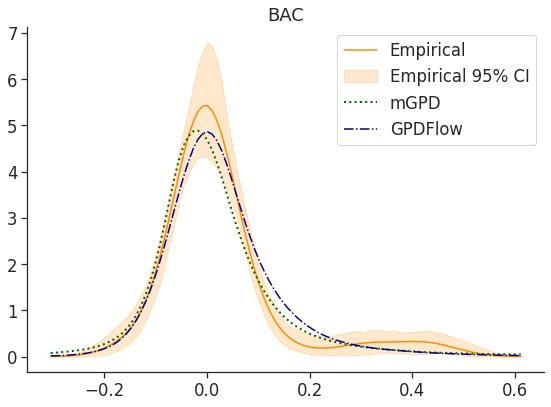

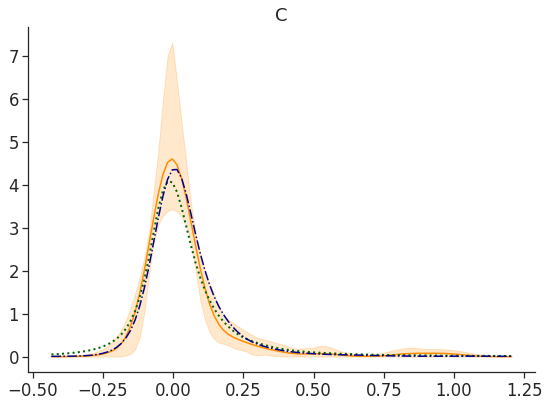

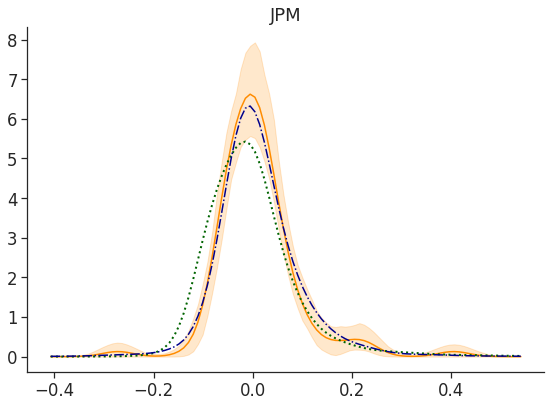

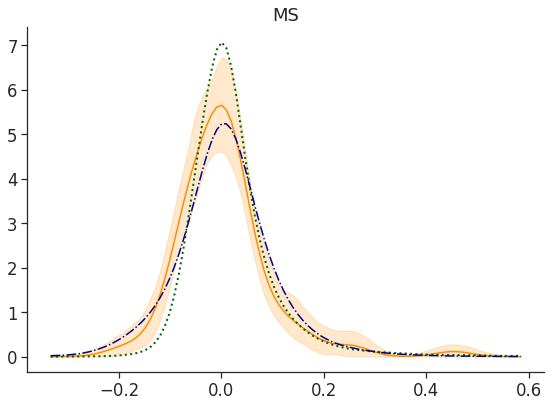

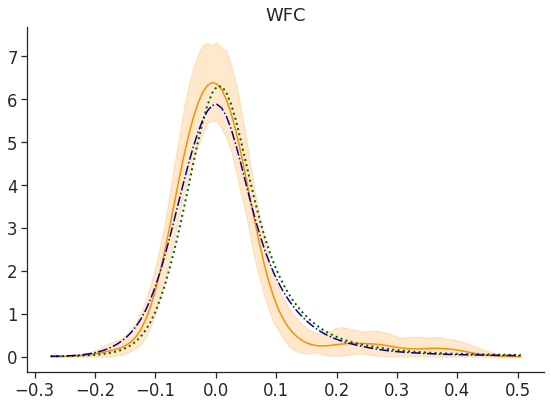

In [25]:

for i in range(dimensions):
    # Create a separate figure for each dimension
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Define an x-grid based on the empirical data in dimension i.
    tail_range = (samples[:, i].max() - samples[:, i].min()) / 5
    x_grid = np.linspace(samples[:, i].min() - tail_range,
                         samples[:, i].max() + tail_range, n_grid)
    
    # --- Empirical KDE (Full Dataset) ---
    kde_emp = gaussian_kde(samples[:, i])
    y_emp = kde_emp(x_grid)
    ax.plot(x_grid, y_emp, label='Empirical', color='darkorange')
    
    # --- Empirical Bootstrap KDEs for 95% CI ---
    kde_emp_boot = []
    for boot in bootstrap_samples:
        try:
            kde_boot = gaussian_kde(boot[:, i])
            y_boot = kde_boot(x_grid)
        except np.linalg.LinAlgError:
            y_boot = np.zeros_like(x_grid)
        kde_emp_boot.append(y_boot)
    kde_emp_boot = np.array(kde_emp_boot)
    lower_bound = np.percentile(kde_emp_boot, 2.5, axis=0)
    upper_bound = np.percentile(kde_emp_boot, 97.5, axis=0)
    ax.fill_between(x_grid, lower_bound, upper_bound, color='darkorange', alpha=0.2,
                    label='Empirical 95% CI')
    
    # --- mGPD Predictions KDE (Monte Carlo Mean) ---
    kde_mGPD_boot = []
    for boot in bootstrap_mGPD:
        try:
            kde_boot = gaussian_kde(boot[:, i])
            y_boot = kde_boot(x_grid)
        except np.linalg.LinAlgError:
            y_boot = np.zeros_like(x_grid)
        kde_mGPD_boot.append(y_boot)
    kde_mGPD_boot = np.array(kde_mGPD_boot)
    mGPD_mean = np.mean(kde_mGPD_boot, axis=0)
    ax.plot(x_grid, mGPD_mean, label='mGPD', color='darkgreen', linestyle = 'dotted',lw=2)
    
    # --- GPDFlow Predictions KDE (Monte Carlo Mean) ---
    kde_GPDFlow_boot = []
    for boot in bootstrap_GPDFlow:
        try:
            kde_boot = gaussian_kde(boot[:, i])
            y_boot = kde_boot(x_grid)
        except np.linalg.LinAlgError:
            y_boot = np.zeros_like(x_grid)
        kde_GPDFlow_boot.append(y_boot)
    kde_GPDFlow_boot = np.array(kde_GPDFlow_boot)
    GPDFlow_mean = np.mean(kde_GPDFlow_boot, axis=0)
    ax.plot(x_grid, GPDFlow_mean, label='GPDFlow', color='darkblue',linestyle = 'dashdot')
    
    ax.set_title(f"{df.columns[i]}")
    if i == 0:
        ax.legend()
    sns.despine()
    plt.tight_layout()
    plt.savefig(dir_out + 'Plots/'+f'marginal_density_{i}.pdf',bbox_inches='tight')
    plt.show()


#### Dependence Comparisons

The following plotting code will do:
1. Draw the bootstrap mean and 95% bootstrap confidence interval of the $\chi_{1:5}(q)$ and $\omega_{1:5}(q)$ of the threshold exceedance data 
2. Draw the Monte Carlo mean of the $\chi_{1:5}(q)$ and $\omega_{1:5}(q)$  of the mGPD
3. Draw the Monte Carlo mean of the $\chi_{1:5}(q)$ and $\omega_{1:5}(q)$  of the GPDFlow

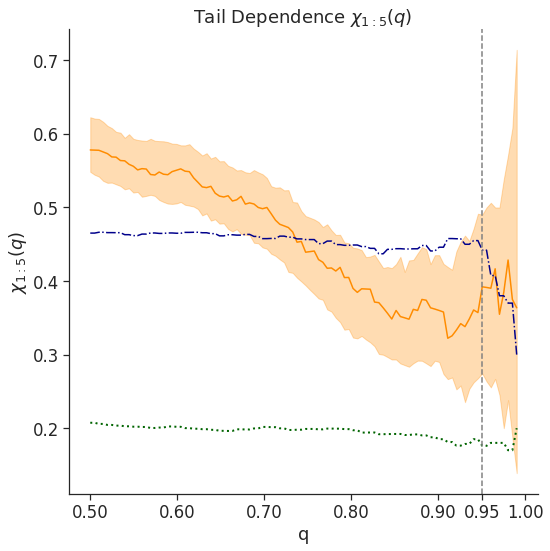

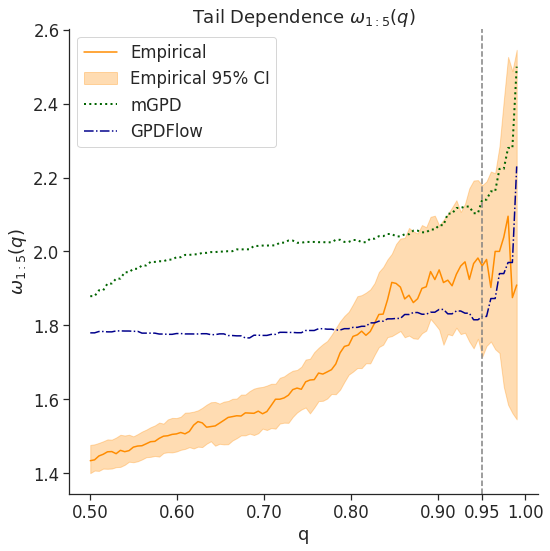

In [26]:
# ----- 2. Tail Dependence Measures via Bootstrap -----
# For a grid of thresholds p in [0.50, 0.99] we compute:
#   - χ (using cond='and')
#   - ω (using cond='or')
#
# For each bootstrap replicate (for each dataset), we calculate the measure.
# Then we plot the Monte Carlo (bootstrap) mean for each dataset.
# For the empirical samples we also add the 95% CI (shaded area).

p_grid = np.linspace(0.50, 0.99, 100)

# Initialize arrays to store the tail dependence measures for each bootstrap replicate.
chi_empirical_boot = np.zeros((n_bootstrap, len(p_grid)))
chi_mGPD_boot      = np.zeros((n_bootstrap, len(p_grid)))
chi_GPDFlow_boot   = np.zeros((n_bootstrap, len(p_grid)))

omega_empirical_boot = np.zeros((n_bootstrap, len(p_grid)))
omega_mGPD_boot      = np.zeros((n_bootstrap, len(p_grid)))
omega_GPDFlow_boot   = np.zeros((n_bootstrap, len(p_grid)))

# Loop over bootstrap replicates and thresholds.
for b in range(n_bootstrap):
    emp_data    = bootstrap_samples_origin[b]
    mGPD_data   = bootstrap_mGPD[b]
    GPDFlow_data= bootstrap_GPDFlow[b]
    for j, p_val in enumerate(p_grid):
        # Compute χ (cond='and')
        chi_empirical_boot[b, j] = empirical_tail_dependence_measure(emp_data, p_val, cond='and')
        chi_mGPD_boot[b, j]      = empirical_tail_dependence_measure(mGPD_data, p_val, cond='and')
        chi_GPDFlow_boot[b, j]   = empirical_tail_dependence_measure(GPDFlow_data, p_val, cond='and')
        
        # Compute ω (cond='or')
        omega_empirical_boot[b, j] = empirical_tail_dependence_measure(emp_data, p_val, cond='or')
        omega_mGPD_boot[b, j]      = empirical_tail_dependence_measure(mGPD_data, p_val, cond='or')
        omega_GPDFlow_boot[b, j]   = empirical_tail_dependence_measure(GPDFlow_data, p_val, cond='or')

# Compute means and 95% CIs for the empirical tail dependence measures
chi_empirical_mean  = np.array(chi_emp)
chi_empirical_lower = np.percentile(chi_empirical_boot, 2.5, axis=0)
chi_empirical_upper = np.percentile(chi_empirical_boot, 97.5, axis=0)

chi_mGPD_mean    = np.mean(chi_mGPD_boot, axis=0)
chi_GPDFlow_mean = np.mean(chi_GPDFlow_boot, axis=0)

omega_empirical_mean  = np.array(omega_emp)
omega_empirical_lower = np.percentile(omega_empirical_boot, 2.5, axis=0)
omega_empirical_upper = np.percentile(omega_empirical_boot, 97.5, axis=0)

omega_mGPD_mean    = np.mean(omega_mGPD_boot, axis=0)
omega_GPDFlow_mean = np.mean(omega_GPDFlow_boot, axis=0)

# ----- Plot Tail Dependence (χ) for cond='and' -----
fig, ax = plt.subplots(figsize=(8, 8))
ticks =  [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
ax.plot(p_grid, chi_empirical_mean, label='Empirical', color='darkorange')
ax.fill_between(p_grid, chi_empirical_lower, chi_empirical_upper, color='darkorange', alpha=0.3,
                label='Empirical 95% CI')
ax.plot(p_grid, chi_mGPD_mean, label='mGPD', color='darkgreen',linestyle = 'dotted',lw=2)
ax.plot(p_grid, chi_GPDFlow_mean, label='GPDFlow', color='darkblue',linestyle = 'dashdot')
ax.axvline(x=0.95, color='gray', linestyle='--')
ax.set_title(r"Tail Dependence $\chi_{1:5}(q)$ ")
ax.set_xlabel('q')
ax.set_ylabel(r'$\chi_{1:5}(q)$')
# ax.legend()
sns.despine()
ax.set_xticks(ticks)
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+'chi_estimation.pdf',bbox_inches='tight')
plt.show()

# ----- Plot Tail Dependence (ω) for cond='or' -----
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_grid, omega_empirical_mean, label='Empirical', color='darkorange')
ax.fill_between(p_grid, omega_empirical_lower, omega_empirical_upper, color='darkorange', alpha=0.3,
                label='Empirical 95% CI')
ax.plot(p_grid, omega_mGPD_mean, label='mGPD', color='darkgreen',linestyle = 'dotted', lw=2)
ax.plot(p_grid, omega_GPDFlow_mean, label='GPDFlow', color='darkblue',linestyle = 'dashdot')
ax.axvline(x=0.95, color='gray', linestyle='--')
ax.set_title(r"Tail Dependence $\omega_{1:5}(q)$")
ax.set_xlabel('q')
ax.set_ylabel(r'$\omega_{1:5}(q)$')
ax.legend(loc='upper left')
sns.despine()
ax.set_xticks(ticks)
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+'omega_estimation.pdf',bbox_inches='tight')
plt.show()

# CoVaR of the five banks

Calucate the empirical $\text{CoVaR}_{\alpha,0.95}(.|\text{JPM})$.

In [20]:
CoVaR_samples = samples_origin[samples_origin[:,2]>thres_origin[2],:]
alpha = np.concatenate([np.arange(0.1,1,0.01), np.arange(0.99,0.999,0.001)])
print(alpha)

CoVaR_emp = np.quantile(CoVaR_samples, alpha, axis=0)


[0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21
 0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33
 0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45
 0.46  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57
 0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69
 0.7   0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81
 0.82  0.83  0.84  0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.92  0.93
 0.94  0.95  0.96  0.97  0.98  0.99  0.99  0.991 0.992 0.993 0.994 0.995
 0.996 0.997 0.998 0.999]


Compute the estimated $\text{CoVaR}_{\alpha,0.95}(.|\text{JPM})$ from the fitted GPDFlow, then determine the Monte Carlo mean and its 95% confidence interval.

In [21]:
CoVaR_pred_2 = []
for b in range(n_bootstrap):
    boot_GPDFlow = bootstrap_GPDFlow[b]
    CoVaR_pred_2.append(np.quantile(boot_GPDFlow[boot_GPDFlow[:,2]>0,:], alpha, axis=0)+thres )
    samples_origin[samples_origin[:,2]>thres_origin[2],:]

CoVaR_pred_2 = np.array(CoVaR_pred_2)
CoVaR_pred_2_mean = np.mean(CoVaR_pred_2, axis = 0)
CoVaR_pred_2_upp = np.quantile(CoVaR_pred_2, 0.975, axis = 0)
CoVaR_pred_2_low = np.quantile(CoVaR_pred_2, 0.025, axis = 0)

Visualize the results

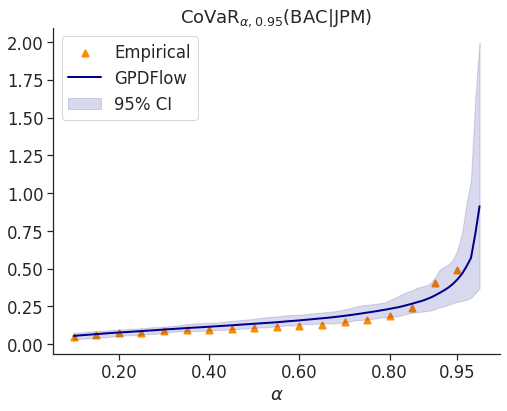

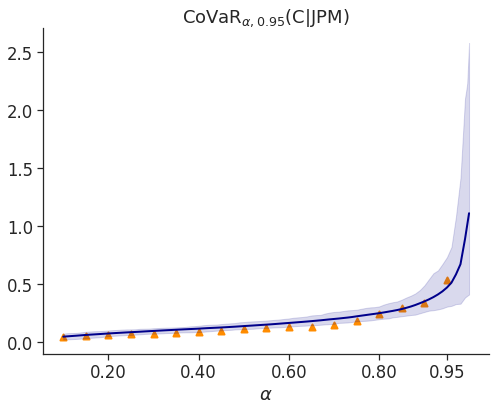

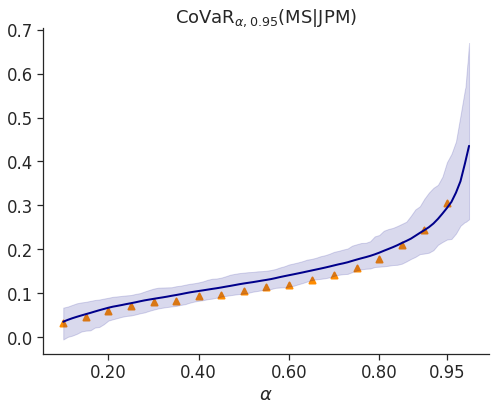

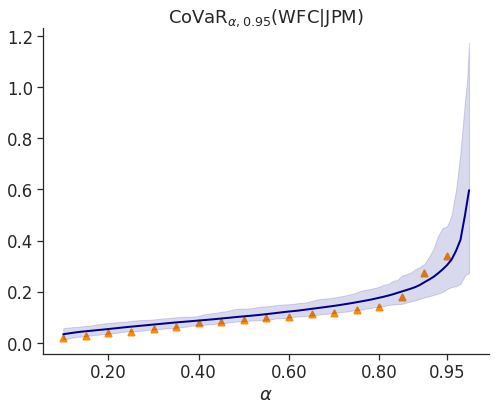

In [31]:
ticks =  [0.2, 0.4, 0.6, 0.8, 0.95]
for j in [0,1,3,4]:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(alpha[:90:5], CoVaR_emp[:90:5,j], label='Empirical', color='darkorange', marker='^', lw=2)
    ax.plot(alpha, CoVaR_pred_2_mean[:,j], label='GPDFlow', color='darkblue', lw=2)
    ax.fill_between(alpha, CoVaR_pred_2_low[:,j], CoVaR_pred_2_upp[:,j], color='darkblue', alpha=0.15,
                        label='95% CI')
    ax.set_title(r"$\text{CoVaR}_{\alpha,0.95}$"+f'({df.columns[j]}|JPM)')
    ax.set_xlabel(r'$\alpha$')
    if j == 0:
        ax.legend(loc='upper left')
    ax.set_xticks(ticks)
    sns.despine()
    plt.savefig(dir_out + 'Plots/'+f'CoVaR({df.columns[j]}_JPM).pdf',bbox_inches='tight')
    plt.show()